In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load and preprocess the dataset
df = pd.read_csv("graded_exams.csv")
df = df.dropna()

# Shuffle the dataset
shuffled_data = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [2]:
# Encode categorical variables
label_encoders = {}
categorical_columns = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    shuffled_data[column] = label_encoders[column].fit_transform(shuffled_data[column])

# Define rule-based grading function with categorical conditions
def assign_grade(score, lunch, test_prep, parent_edu):
    # Small grade boost for students who had a standard lunch
    grade_boost = 1 if lunch == 1 else 0  # Assuming "1" means standard lunch

    # Adjust failure threshold if the student completed test prep
    failure_threshold = 71 if test_prep == 1 else 73  # Lower passing threshold if test prep was taken

    # Parental education adjustment (Example: If parent has 'some high school', score needs +1 to pass)
    parent_edu_adjustment = 1 if parent_edu == 0 else 0  # Assuming '0' is "some high school"

    adjusted_score = score + grade_boost + parent_edu_adjustment

    if adjusted_score >= 97:
        return "Excellent"
    elif adjusted_score >= 93:
        return "Superior"
    elif adjusted_score >= 89:
        return "Good"
    elif adjusted_score >= 85:
        return "Above Average"
    elif adjusted_score >= 81:
        return "Average"
    elif adjusted_score >= 77:
        return "Below Average"
    elif adjusted_score >= failure_threshold:
        return "Passing"
    else:
        return "Failure"

In [3]:
# Apply the updated function to assign grades
shuffled_data["math grade"] = shuffled_data.apply(lambda row: assign_grade(row["math score"], row["lunch"], row["test preparation course"], row["parental level of education"]), axis=1)
shuffled_data["reading grade"] = shuffled_data.apply(lambda row: assign_grade(row["reading score"], row["lunch"], row["test preparation course"], row["parental level of education"]), axis=1)
shuffled_data["writing grade"] = shuffled_data.apply(lambda row: assign_grade(row["writing score"], row["lunch"], row["test preparation course"], row["parental level of education"]), axis=1)

# Features and target variables
features = shuffled_data.drop(columns=['math score', 'reading score', 'writing score', 'math grade', 'reading grade', 'writing grade'])
target_math = shuffled_data['math grade']
target_reading = shuffled_data['reading grade']
target_writing = shuffled_data['writing grade']

In [4]:
# Split dataset (70-20-10 split)
X_train, X_temp, y_train_math, y_temp_math, y_train_reading, y_temp_reading, y_train_writing, y_temp_writing = train_test_split(
    features, target_math, target_reading, target_writing, test_size=0.3, random_state=42
)
X_test, X_unseen, y_test_math, y_unseen_math, y_test_reading, y_unseen_reading, y_test_writing, y_unseen_writing = train_test_split(
    X_temp, y_temp_math, y_temp_reading, y_temp_writing, test_size=1/3, random_state=42
)

In [5]:
# Apply rule-based classifier with categorical columns
y_pred_math = shuffled_data.apply(lambda row: assign_grade(row["math score"], row["lunch"], row["test preparation course"], row["parental level of education"]), axis=1)
y_pred_reading = shuffled_data.apply(lambda row: assign_grade(row["reading score"], row["lunch"], row["test preparation course"], row["parental level of education"]), axis=1)
y_pred_writing = shuffled_data.apply(lambda row: assign_grade(row["writing score"], row["lunch"], row["test preparation course"], row["parental level of education"]), axis=1)

# Evaluate rule-based classifier
def evaluate_rule_based(y_true, y_pred, target_name):
    print(f"{target_name} Grade Prediction (Rule-Based Classifier)")
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    print(classification_report(y_true, y_pred))
    print()

# Evaluate on test set
evaluate_rule_based(y_test_math, y_pred_math.loc[y_test_math.index], "Math")
evaluate_rule_based(y_test_reading, y_pred_reading.loc[y_test_reading.index], "Reading")
evaluate_rule_based(y_test_writing, y_pred_writing.loc[y_test_writing.index], "Writing")

Math Grade Prediction (Rule-Based Classifier)
Accuracy: 1.00
               precision    recall  f1-score   support

Above Average       1.00      1.00      1.00         8
      Average       1.00      1.00      1.00        14
Below Average       1.00      1.00      1.00        14
    Excellent       1.00      1.00      1.00         5
      Failure       1.00      1.00      1.00       115
         Good       1.00      1.00      1.00         7
      Passing       1.00      1.00      1.00        34
     Superior       1.00      1.00      1.00         3

     accuracy                           1.00       200
    macro avg       1.00      1.00      1.00       200
 weighted avg       1.00      1.00      1.00       200


Reading Grade Prediction (Rule-Based Classifier)
Accuracy: 1.00
               precision    recall  f1-score   support

Above Average       1.00      1.00      1.00        16
      Average       1.00      1.00      1.00        16
Below Average       1.00      1.00      1.00 

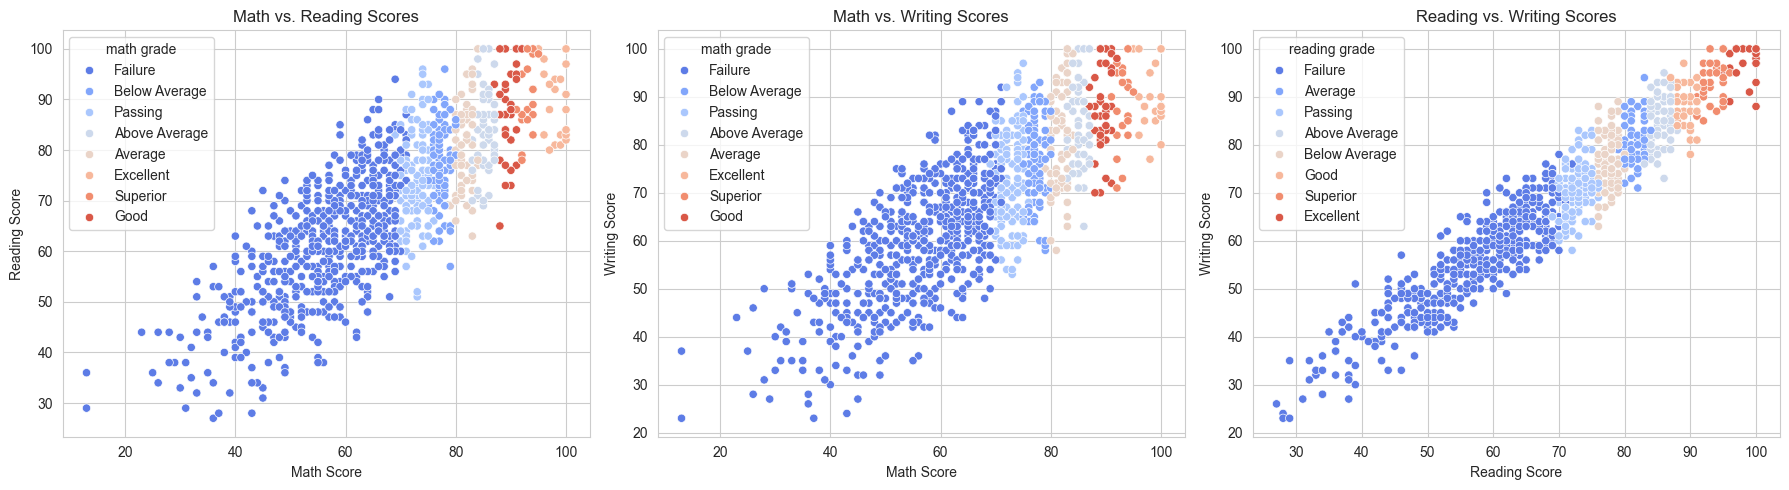

In [6]:
# Set Seaborn style
sns.set_style("whitegrid")

# Create scatter plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Scatter plot for Math vs Reading
sns.scatterplot(x=shuffled_data["math score"], y=shuffled_data["reading score"],
                hue=shuffled_data["math grade"], palette="coolwarm", ax=axes[0])
axes[0].set_title("Math vs. Reading Scores")
axes[0].set_xlabel("Math Score")
axes[0].set_ylabel("Reading Score")

# Scatter plot for Math vs Writing
sns.scatterplot(x=shuffled_data["math score"], y=shuffled_data["writing score"],
                hue=shuffled_data["math grade"], palette="coolwarm", ax=axes[1])
axes[1].set_title("Math vs. Writing Scores")
axes[1].set_xlabel("Math Score")
axes[1].set_ylabel("Writing Score")

# Scatter plot for Reading vs Writing
sns.scatterplot(x=shuffled_data["reading score"], y=shuffled_data["writing score"],
                hue=shuffled_data["reading grade"], palette="coolwarm", ax=axes[2])
axes[2].set_title("Reading vs. Writing Scores")
axes[2].set_xlabel("Reading Score")
axes[2].set_ylabel("Writing Score")

# Adjust layout and show plot
plt.tight_layout()
plt.show()


Math Evaluation on Unseen Data
Accuracy: 1.00
               precision    recall  f1-score   support

Above Average       1.00      1.00      1.00        54
      Average       1.00      1.00      1.00        64
Below Average       1.00      1.00      1.00        92
    Excellent       1.00      1.00      1.00        26
      Failure       1.00      1.00      1.00       583
         Good       1.00      1.00      1.00        38
      Passing       1.00      1.00      1.00       122
     Superior       1.00      1.00      1.00        20

     accuracy                           1.00       999
    macro avg       1.00      1.00      1.00       999
 weighted avg       1.00      1.00      1.00       999



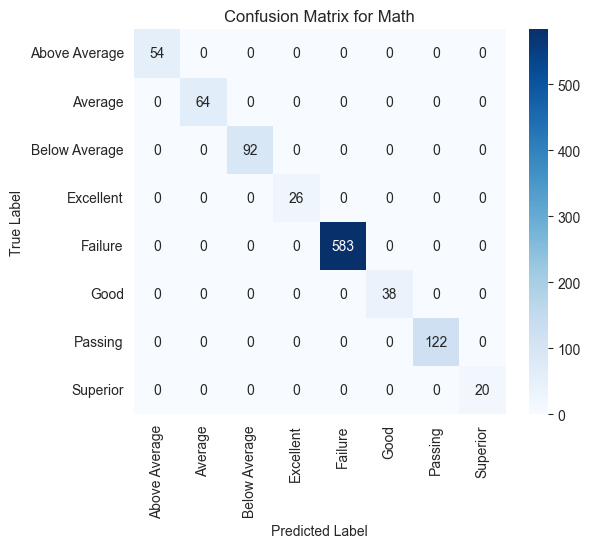


Reading Evaluation on Unseen Data
Accuracy: 1.00
               precision    recall  f1-score   support

Above Average       1.00      1.00      1.00        73
      Average       1.00      1.00      1.00        67
Below Average       1.00      1.00      1.00        99
    Excellent       1.00      1.00      1.00        30
      Failure       1.00      1.00      1.00       512
         Good       1.00      1.00      1.00        41
      Passing       1.00      1.00      1.00       146
     Superior       1.00      1.00      1.00        31

     accuracy                           1.00       999
    macro avg       1.00      1.00      1.00       999
 weighted avg       1.00      1.00      1.00       999



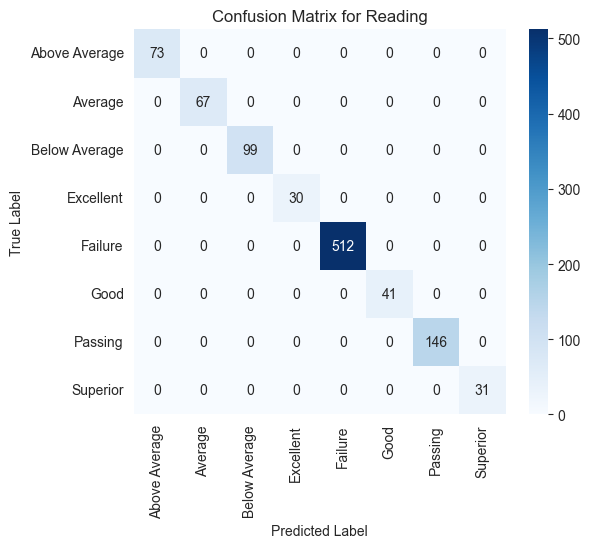


Writing Evaluation on Unseen Data
Accuracy: 1.00
               precision    recall  f1-score   support

Above Average       1.00      1.00      1.00        57
      Average       1.00      1.00      1.00        75
Below Average       1.00      1.00      1.00        71
    Excellent       1.00      1.00      1.00        34
      Failure       1.00      1.00      1.00       557
         Good       1.00      1.00      1.00        47
      Passing       1.00      1.00      1.00       128
     Superior       1.00      1.00      1.00        30

     accuracy                           1.00       999
    macro avg       1.00      1.00      1.00       999
 weighted avg       1.00      1.00      1.00       999



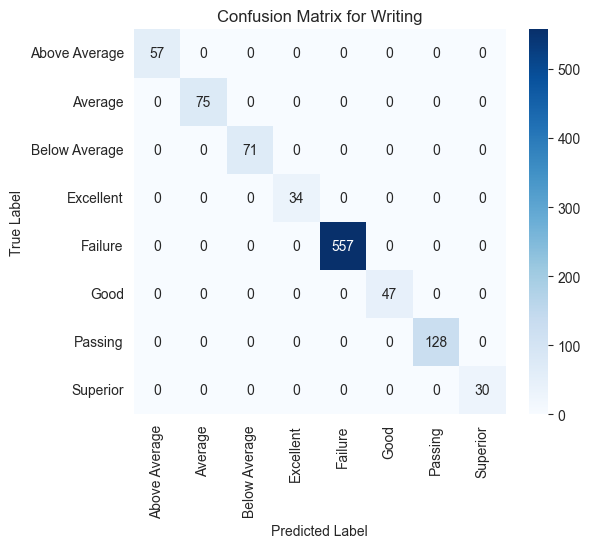

In [7]:
# Function to evaluate unseen data
def evaluate_on_unseen(y_true, y_pred, subject):
    print(f"\n{subject} Evaluation on Unseen Data")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
    print(classification_report(y_true, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix for {subject}")
    plt.show()

# Apply rule-based classifier with categorical columns
y_unseen_math = shuffled_data.apply(lambda row: assign_grade(row["math score"], row["lunch"], row["test preparation course"], row["parental level of education"]), axis=1)
y_unseen_reading = shuffled_data.apply(lambda row: assign_grade(row["reading score"], row["lunch"], row["test preparation course"], row["parental level of education"]), axis=1)
y_unseen_writing = shuffled_data.apply(lambda row: assign_grade(row["writing score"], row["lunch"], row["test preparation course"], row["parental level of education"]), axis=1)


# Evaluate on unseen dataset
evaluate_on_unseen(y_unseen_math, y_unseen_math, "Math")
evaluate_on_unseen(y_unseen_reading, y_unseen_reading, "Reading")
evaluate_on_unseen(y_unseen_writing, y_unseen_writing, "Writing")